# IoT Anomaly Detection (Malfunction)

In [1]:
import numpy as np
import pathlib
import random
import pandas as pd
import tensorflow as tf
import os
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
import seaborn as sns; sns.set()
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from sklearn.metrics import make_scorer, accuracy_score, precision_score
from sklearn.svm import OneClassSVM
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import MinMaxScaler

In [2]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [3]:
data_path_1 = "/content/gdrive/My Drive/NNdataset/Occupancy.csv"
data_path_2 = "/content/gdrive/My Drive/NNdataset/HVAC_Dynamic_Fuzzy_PID_2017_with_Target.csv"
data_path_3 = "/content/gdrive/My Drive/NNdataset/anomaly_detection_sample_1577622599.csv"
rm_occ_dataset = pd.read_csv(data_path_1)
hvac_dataset = pd.read_csv(data_path_2)
madi_dataset = pd.read_csv(data_path_3)
print(f"rm_occ: {rm_occ_dataset.shape}, hvac: {hvac_dataset.shape}, madi: {madi_dataset.shape}")

rm_occ: (20560, 7), hvac: (10000, 17), madi: (60425, 10)


In [5]:
rm_occ_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20560 entries, 0 to 20559
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           20560 non-null  object 
 1   Temperature    20560 non-null  float64
 2   Humidity       20560 non-null  float64
 3   Light          20560 non-null  float64
 4   CO2            20560 non-null  float64
 5   HumidityRatio  20560 non-null  float64
 6   Occupancy      20560 non-null  int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 1.1+ MB


In [6]:
madi_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60425 entries, 0 to 60424
Data columns (total 10 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   Unnamed: 0                                  60425 non-null  int64  
 1   data:zone_air_heating_temperature_setpoint  60425 non-null  float64
 2   data:zone_air_temperature_sensor            60425 non-null  float64
 3   data:zone_air_cooling_temperature_setpoint  60425 non-null  float64
 4   data:supply_air_flowrate_sensor             60425 non-null  float64
 5   data:supply_air_damper_percentage_command   60425 non-null  float64
 6   data:supply_air_flowrate_setpoint           60425 non-null  float64
 7   dow                                         60425 non-null  int64  
 8   hod                                         60425 non-null  int64  
 9   class_label                                 60425 non-null  int64  
dtypes: float64

In [ ]:
print(hvac_dataset.loc[0])

Timestamp                     2017-01-01 00:00:00
Temperature_C                           22.494481
Humidity_%                              44.945633
CO2_ppm                                983.998649
Occupancy_Count                                12
External_Temperature_C                   7.752784
Kp                                       2.055758
Ki                                       0.113566
Kd                                       0.448615
Fuzzy_Adjustment_Factor                  0.850555
ISA_Optimization_Score                  80.205161
HVAC_Power_Consumption_kWh               8.944362
Cooling_Heating_Output_C                 0.559912
Response_Time_s                           7.19128
Energy_Efficiency_%                     80.040141
User_Comfort_Index                              8
HVAC_Efficiency_Class                           2
Name: 0, dtype: object


In [ ]:
# check number of occupied and unoccupied
negative_rm_occ = rm_occ_dataset[rm_occ_dataset['Occupancy'] == 0]
positive_rm_occ = rm_occ_dataset[rm_occ_dataset['Occupancy'] == 1]
print(len(negative_rm_occ))
# too many unoccupied, so need to reduce the number of unoccupied data
reduced_neg_rm_occ = negative_rm_occ.sample(n=len(positive_rm_occ))
print(len(reduced_neg_rm_occ))
balanced_rm_occ = pd.concat([positive_rm_occ,reduced_neg_rm_occ])
balanced_rm_occ = balanced_rm_occ.drop('date',axis=1)

15810
4750


In [ ]:
# train process
def verifier_train_eval(learning_algo, x_train, y_train, x_val, y_val, x_test, y_test, df_rec=None):
    """
    Trains and evaluates the generic model with per-attack type analysis.

    Args:
        learning_algo: The learning algorithm to use
        x_train, y_train: Training data
        x_val, y_val: Validation data
        x_test, y_test: Test data
        df_rec: Original labels with attack types

    Returns:
    list: Indices of false positive predictions
    """
    # Train the model
    if type(learning_algo).__name__ == "IsolationForest":
      learning_algo.fit(x_train)
    else:
      learning_algo.fit(x_train, y_train, x_val, y_val)

    if type(learning_algo).__name__=="AutoEncoderLearningAlgorithm":
      x_pred = learning_algo._model(x_train)
      reconstruction_errors = np.mean(np.power(x_train - x_pred, 2), axis=1)
      learning_algo.threshold = np.mean(reconstruction_errors) - 0.2*np.std(reconstruction_errors)
      # learning_algo.threshold = 0.35
      print(f"threshold: {learning_algo.threshold}")

    # Get predictions
    y_pred = learning_algo.predict(x_test)

    print(type(y_pred).__name__)
    print(type(y_test).__name__)
    if type(y_pred).__name__ == "EagerTensor":
      y_pred = y_pred.numpy()



    # print(list(set(y_pred)))
    # print(list(set(y_test)))

    # Create confusion matrix
    mat = confusion_matrix(y_test, y_pred)
    print(mat)

    # Plot 1: Overall confusion matrix
    fig, axs = plt.subplots(1, 3, figsize=(14, 6))
    sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
                xticklabels=['Unoccupied', 'Occupied'],
                yticklabels=['Unoccupied', 'Occupied'], ax=axs[0])
    axs[0].set_xlabel('True label')
    axs[0].set_ylabel('Predicted label')
    axs[0].set_title('Overall Confusion Matrix')
    print(classification_report(y_test, y_pred,
                              target_names=['%d' %i for i in range(2)]))
    scorer = make_scorer(precision_score)
    result = permutation_importance(learning_algo, x_test, y_test, n_repeats=10, scoring=scorer)
    label = []
    size = []
    sum = 0
    for i in range(x_train.shape[1]):
      label.append(f"feature {i}")
      sum = sum + abs(result.importances_mean[i])
      print(f"Feature {i}: {result.importances_mean[i]:.3f} (±{result.importances_std[i]:.3f})")

    for i in range(x_train.shape[1]):
      size.append(abs(result.importances_mean[i])/sum*100)

    axs[1].pie(size, labels=label,
        autopct='%1.1f%%', shadow=False, startangle=140)

    axs[1].set_title('Permutation Importance')
    axs[1].axis('equal')
    # if type(learning_algo._model).__name__ == "Autoencoder":
    #   y_proba = y_pred.ravel()
    # elif  type(learning_algo._model).__name__ == "IsolationForest" or type(learning_algo._model).__name__== "OneClassSVM":
    #   scores = learning_algo._model.decision_function(x_test)
    #   y_proba_like = scores
    #   scaler = MinMaxScaler()
    #   y_proba = scaler.fit_transform(y_proba_like.reshape(-1, 1)).ravel()
    # else:
    #   y_proba = learning_algo._model.predict_proba(x_test)[:,1]
    # fpr, tpr, thresholds = roc_curve(y_test, y_proba)
    # roc_auc = auc(fpr, tpr)
    # axs[2].plot(fpr, tpr, lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    # axs[2].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    # axs[2].set_xlim([0.0, 1.0])
    # axs[2].set_ylim([0.0, 1.05])
    # axs[2].set_xlabel('False Positive Rate')
    # axs[2].set_ylabel('True Positive Rate')
    # axs[2].set_title('ROC Curve')
    # axs[2].legend(loc="lower right")
    plt.tight_layout()
    plt.show()

In [ ]:
# generate train test dataset


train, rest = train_test_split(balanced_rm_occ, train_size=0.8, shuffle=True)
test, val = train_test_split(rest, train_size=0.8, shuffle=True)

y_train = train['Occupancy'].copy()
y_test = test['Occupancy'].copy()
y_val = val['Occupancy'].copy()

x_train = train.drop('Occupancy',axis=1)
x_test = test.drop('Occupancy',axis=1)
x_val = val.drop('Occupancy',axis=1)



ndarray
Series
[[756  10]
 [  8 746]]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       766
           1       0.99      0.99      0.99       754

    accuracy                           0.99      1520
   macro avg       0.99      0.99      0.99      1520
weighted avg       0.99      0.99      0.99      1520

Feature 0: -0.000 (±0.000)
Feature 1: 0.000 (±0.000)
Feature 2: 0.466 (±0.011)
Feature 3: 0.000 (±0.000)
Feature 4: 0.000 (±0.000)


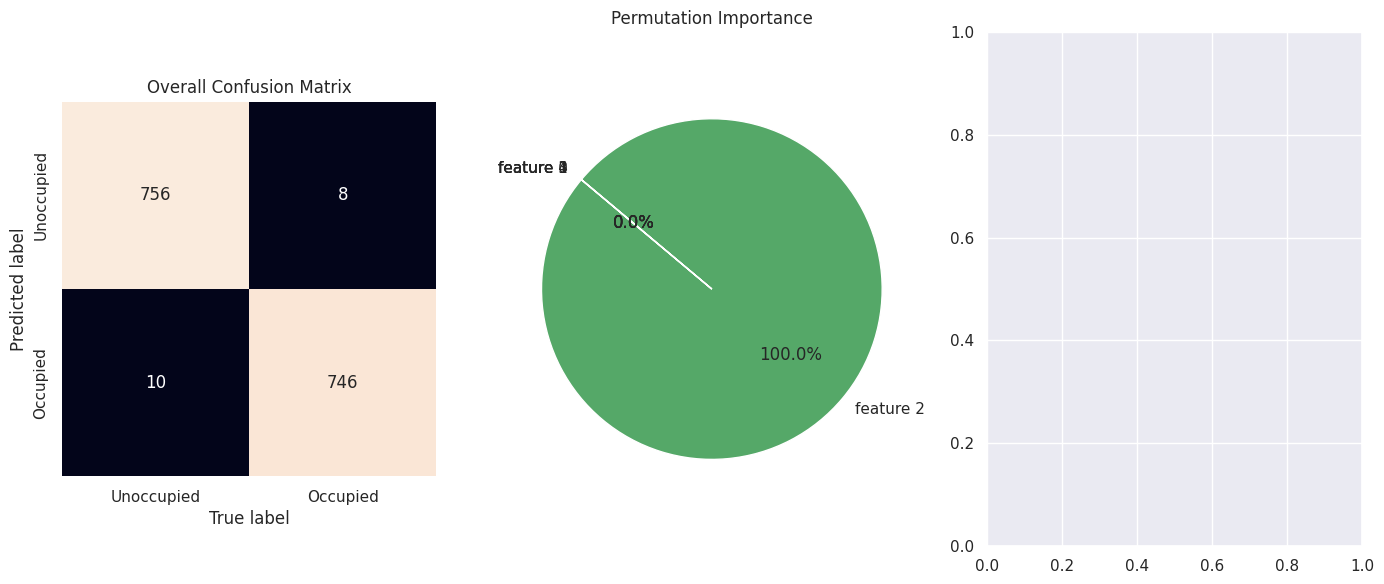

In [ ]:
# random forest baseline
class RandomForestLearningAlgorithm():
    def __init__(self, n_estimators:int,criterion,max_depth:int,min_samples_split:int):
        self._model = RandomForestClassifier(n_estimators=n_estimators,criterion=criterion,max_depth=max_depth,min_samples_split=min_samples_split)
    def fit(self, x_train:np.array, y_train: np.array, x_val:np.array, y_val: np.array) -> None:
      self._model.fit(X=x_train,y=y_train)

    def predict(self, x_test: np.array) -> np.array:
      return self._model.predict(x_test)

    @property
    def name(self) -> str:
      return 'random forest'
rd_forest = RandomForestLearningAlgorithm(n_estimators = 300, criterion = 'gini', max_depth = 5, min_samples_split = 2)
verifier_train_eval(rd_forest, x_train, y_train, x_val, y_val, x_test, y_test)

In [ ]:
# iso forest for un supervised training
class IsoForestLearningAlgorithm():
    def __init__(self, n_estimators:int,max_features,contamination=float(0.1),max_samples="auto"):
        self._model =IsolationForest(n_estimators=n_estimators,max_features=max_features,contamination=contamination,max_samples=max_samples)


    def fit(self, x_train:np.array, y_train: np.array, x_val:np.array, y_val: np.array) -> None:
      self._model.fit(x_train)

    def predict(self, x_test: np.array) -> np.array:
      y_pred = self._model.predict(x_test)
      for i in range(len(y_pred)):
        if y_pred[i] == -1: y_pred[i] = 0
      return y_pred

    def get_scorer(self):
        return make_scorer(precision_score)

    @property
    def name(self) -> str:
      return 'iso forest'



In [ ]:
# isolation forest need more normal (over 90%) to learn the normal trend so need to modified the training dataset, the anomous data is added through contamination
train_iso, rest_iso = train_test_split(positive_rm_occ, train_size=0.8, shuffle=True)

train_iso_y = train_iso['Occupancy']
train_iso_x = train_iso.drop(['Occupancy','date'],axis=1)

ndarray
Series
[[693  73]
 [ 82 672]]
              precision    recall  f1-score   support

           0       0.89      0.90      0.90       766
           1       0.90      0.89      0.90       754

    accuracy                           0.90      1520
   macro avg       0.90      0.90      0.90      1520
weighted avg       0.90      0.90      0.90      1520

Feature 0: 0.039 (±0.009)
Feature 1: -0.031 (±0.003)
Feature 2: 0.201 (±0.010)
Feature 3: 0.007 (±0.006)
Feature 4: -0.026 (±0.007)


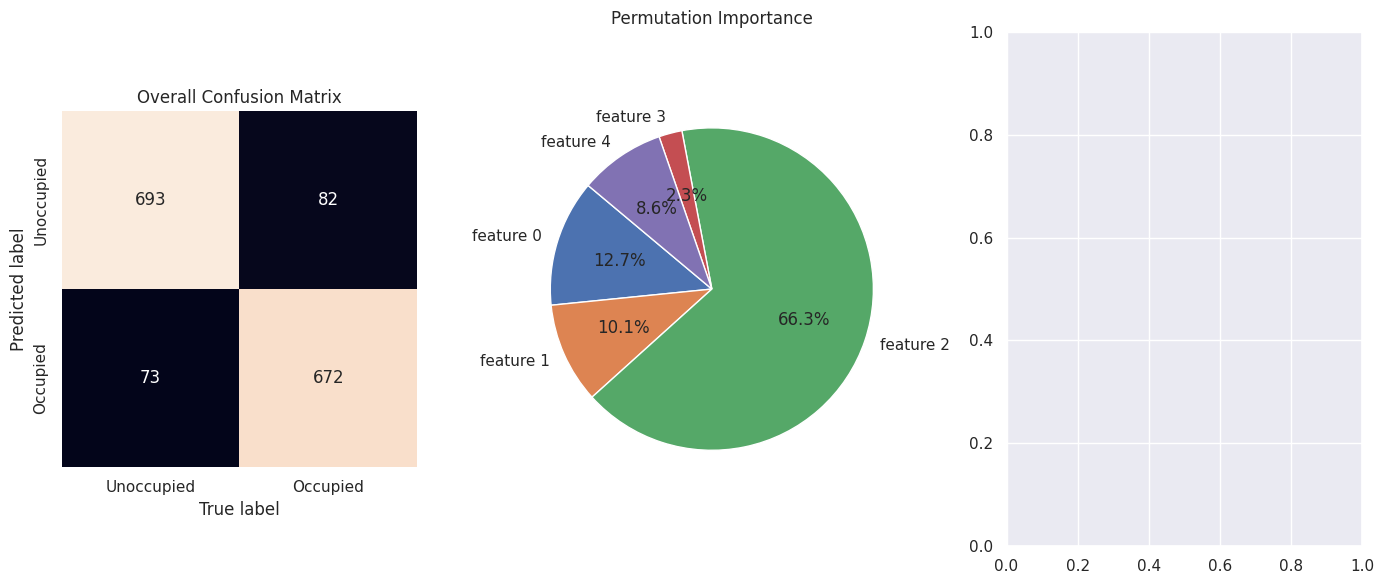

In [ ]:
iso_forest = IsoForestLearningAlgorithm(n_estimators = 300, max_features=0.8)
verifier_train_eval(iso_forest, train_iso_x, y_train, x_val, y_val, x_test, y_test)

In [ ]:
print(type(iso_forest._model).__name__)
print(type(autoencoder._model).__name__)
print(type(oSVM._model).__name__)
print(type(rd_forest._model).__name__)

IsolationForest
Autoencoder
OneClassSVM
RandomForestClassifier


In [ ]:
# One Class SVM
class OneClassSVMLearningAlgorithm():
    def __init__(self, nu=0.1,gamma=0.1):
        self._model = OneClassSVM(kernel="rbf", nu=nu, gamma=gamma)


    def fit(self, x_train:np.array, y_train: np.array, x_val:np.array, y_val: np.array) -> None:
      self._model.fit(x_train)

    def predict(self, x_test: np.array) -> np.array:
      y_pred = self._model.predict(x_test)
      for i in range(len(y_pred)):
        if y_pred[i] == -1: y_pred[i] = 0
      return y_pred

    def get_scorer(self):
        return make_scorer(precision_score)

    @property
    def name(self) -> str:
      return 'one class SVM'

In [ ]:
# as one class svm need gamma match the percent of anomous data in training dataset, so need to modify the dataset
gamma = 0.1
reduced_neg_rm_occ = negative_rm_occ.sample(n=int(len(positive_rm_occ)*gamma))
print(len(reduced_neg_rm_occ))
balanced_rm_occ = pd.concat([positive_rm_occ,reduced_neg_rm_occ])
balanced_rm_occ = balanced_rm_occ.drop('date',axis=1)

475


In [ ]:
x_train = balanced_rm_occ.drop('Occupancy',axis=1)

ndarray
Series
[[766   0]
 [419 335]]
              precision    recall  f1-score   support

           0       0.65      1.00      0.79       766
           1       1.00      0.44      0.62       754

    accuracy                           0.72      1520
   macro avg       0.82      0.72      0.70      1520
weighted avg       0.82      0.72      0.70      1520

Feature 0: 0.000 (±0.000)
Feature 1: 0.000 (±0.000)
Feature 2: 0.065 (±0.054)
Feature 3: 0.000 (±0.000)
Feature 4: 0.000 (±0.000)


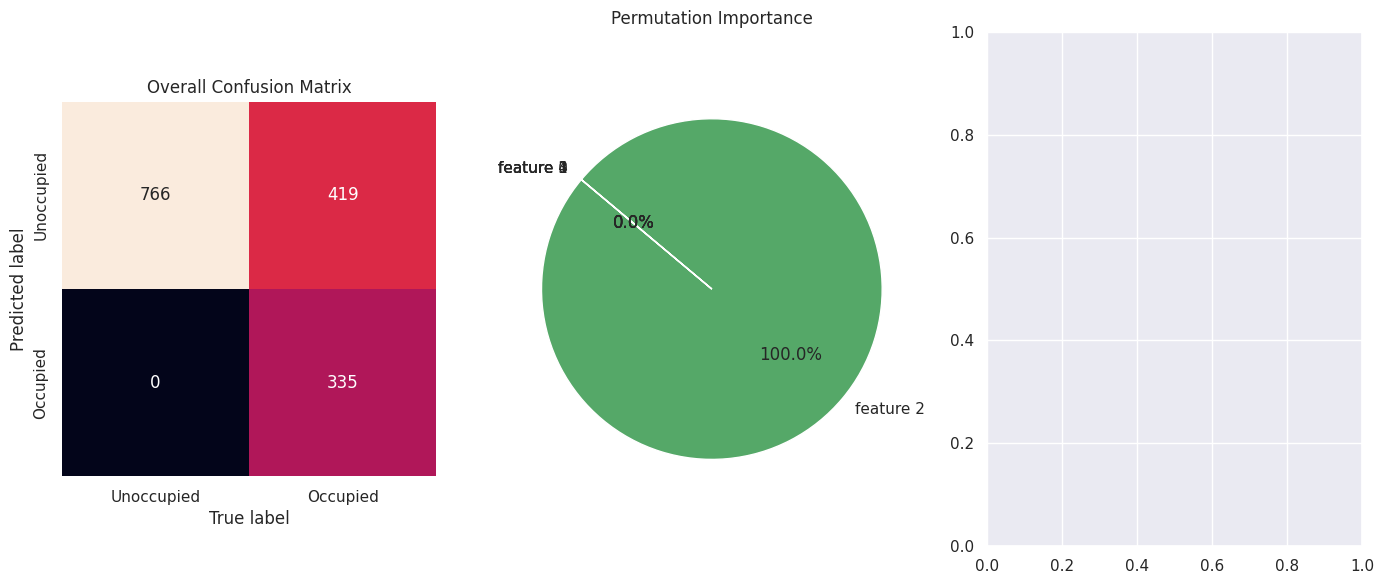

In [ ]:
oSVM = OneClassSVMLearningAlgorithm()
verifier_train_eval(oSVM, train_iso_x, y_train, x_val, y_val, x_test, y_test)

In [ ]:
class Autoencoder(tf.keras.Model):
    def __init__(self, input_shape):
        super(Autoencoder, self).__init__()

        # Encoder
        self.encoder = tf.keras.Sequential([
            # Input layer with normalization
            tf.keras.layers.InputLayer(input_shape=(input_shape,)),
            tf.keras.layers.BatchNormalization(),

            # First encoding layer with L2 regularization
            tf.keras.layers.Dense(256, activation='relu',
                                kernel_regularizer=tf.keras.regularizers.l2(1e-4)),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dropout(0.3),  # Increased dropout

            # Second encoding layer
            tf.keras.layers.Dense(128, activation='relu',
                                kernel_regularizer=tf.keras.regularizers.l2(1e-4)),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dropout(0.3),

            # Smaller bottleneck layer for better compression
            tf.keras.layers.Dense(32, activation='relu', name='bottleneck',
                                kernel_regularizer=tf.keras.regularizers.l2(1e-4)),
            tf.keras.layers.BatchNormalization()
        ])

        # Decoder
        self.decoder = tf.keras.Sequential([
            # First decoding layer
            tf.keras.layers.Dense(128, activation='relu',
                                kernel_regularizer=tf.keras.regularizers.l2(1e-4)),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dropout(0.3),

            # Second decoding layer
            tf.keras.layers.Dense(256, activation='relu',
                                kernel_regularizer=tf.keras.regularizers.l2(1e-4)),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dropout(0.3),

            # Output layer with sigmoid for normalized output
            tf.keras.layers.Dense(input_shape, activation='sigmoid')
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

    def encode(self, x):
        return self.encoder(x)

    def decode(self, x):
        return self.decoder(x)

# Auto encoder
class AutoEncoderLearningAlgorithm():
    def __init__(self, input_shape):
        self._model = Autoencoder(input_shape)
        self._model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                      loss='mean_squared_error')
        self.threshold = 0

    def fit(self, x_train:np.array, y_train: np.array, x_val:np.array, y_val: np.array) -> None:
        history = self._model.fit(
            x_train, x_train,
            epochs=1000,
              batch_size=256,
              validation_data=(x_val, x_val),
              shuffle=True,
              callbacks=[
                  tf.keras.callbacks.EarlyStopping(
                      monitor='val_loss',
                      patience=3,
                      restore_best_weights=True
                    )
                ]
            )
        return history


    def predict(self, x_test: np.array) -> np.array:

      x_pred = self._model(x_test)
      reconstruction_errors = np.mean(np.power(x_test - x_pred, 2), axis=1)
      threshold = self.threshold
      y_pred = []
      for i in range(len(reconstruction_errors)):

        if reconstruction_errors[i] <= threshold:
          y_pred.append(1)
        else: y_pred.append(0)
      return y_pred

    def get_scorer(self):
        return make_scorer(precision_score)

    @property
    def name(self) -> str:
      return 'one class SVM'

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

ae_x_train = scaler.fit_transform(train_iso_x.to_numpy())
ae_y_train = y_train.to_numpy()
ae_x_val = scaler.fit_transform(x_val.to_numpy())
ae_y_val = y_val.to_numpy()
ae_x_test = scaler.fit_transform(x_test.to_numpy())
ae_y_test = y_test.to_numpy()

Epoch 1/1000


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - loss: 1.2062 - val_loss: 0.8304
Epoch 2/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.7258 - val_loss: 0.6853
Epoch 3/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.6155 - val_loss: 0.6624
Epoch 4/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.6105 - val_loss: 0.6454
Epoch 5/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.6053 - val_loss: 0.6228
Epoch 6/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.5912 - val_loss: 0.6113
Epoch 7/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.6060 - val_loss: 0.6048
Epoch 8/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.5980 - val_loss: 0.6024
Epoch 9/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.6048 - val_loss: 0.5998
Epoch 10/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.5986 - val_loss: 0.5990
Epoch 11/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.6030 - val_loss: 0.5967
Epoch 12/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step 

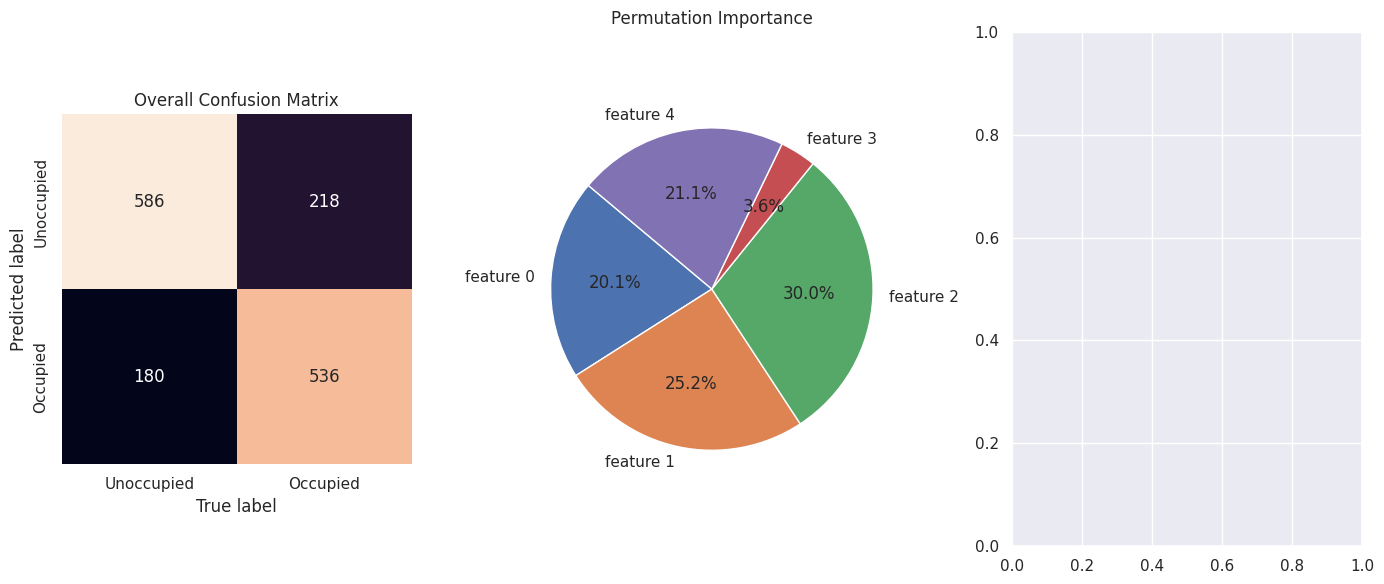

In [ ]:
autoencoder = AutoEncoderLearningAlgorithm(x_train.shape[1])
verifier_train_eval(autoencoder, ae_x_train, ae_y_train, ae_x_val, ae_y_val, ae_x_test, ae_y_test)

In [ ]:
print(type(autoencoder).__name__)

AutoEncoderLearningAlgorithm


In [ ]:
def integrated_gradients(model,
                         input_tensor,
                         baseline=None,
                         target_index=None,
                         steps=50):
    """
    Compute Integrated Gradients for a given input and model.

    Parameters:
    - model: tf.keras.Model
    - input_tensor: tf.Tensor, shape (features,)
    - baseline: tf.Tensor, same shape as input_tensor (default is 0)
    - target_index: int, index of output neuron to compute gradients for (e.g. class)
    - steps: int, number of steps for integration

    Returns:
    - integrated_gradients: np.ndarray, attributions for each input feature
    """
    # Ensure input_tensor is 2D
    input_tensor = tf.cast(tf.convert_to_tensor(input_tensor), tf.float32)
    if len(input_tensor.shape) == 1:
        input_tensor = tf.expand_dims(input_tensor, axis=0)

    # Use zero baseline if not provided
    if baseline is None:
        baseline = tf.zeros_like(input_tensor)

    # Scale inputs and compute gradients
    alphas = tf.linspace(0.0, 1.0, steps+1)
    integrated_grads = tf.zeros_like(input_tensor, dtype=tf.float32)

    for alpha in alphas:
        interpolated = baseline + alpha * (input_tensor - baseline)
        with tf.GradientTape() as tape:
            tape.watch(interpolated)
            prediction = model(interpolated)
            if target_index is not None:
                output = prediction[:, target_index]
            else:
                output = tf.reduce_max(prediction, axis=1)
        grads = tape.gradient(output, interpolated)
        integrated_grads += grads

    # Average gradients and scale by input difference
    avg_grads = integrated_grads / (steps + 1)
    integrated_gradients = (input_tensor - baseline) * avg_grads

    return integrated_gradients.numpy()[0]

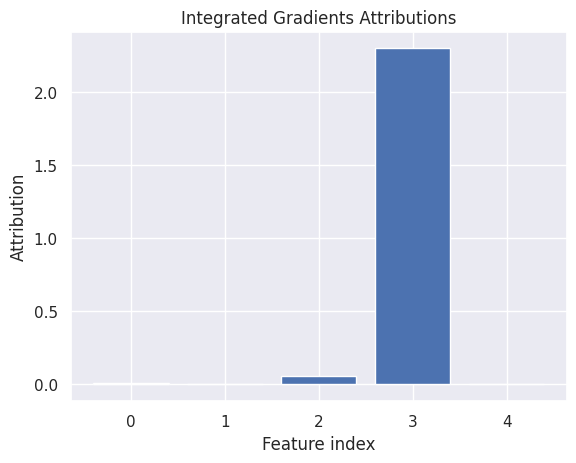

In [ ]:
sample = x_test
# Get IG attributions
attributions = integrated_gradients(autoencoder._model, sample, steps=100)

# Visualize or print
import matplotlib.pyplot as plt
plt.bar(range(len(attributions)), attributions)
plt.title("Integrated Gradients Attributions")
plt.xlabel("Feature index")
plt.ylabel("Attribution")
plt.show()

# MADI dataset

In [ ]:
print(madi_dataset.keys())

Index(['Unnamed: 0', 'data:zone_air_heating_temperature_setpoint',
       'data:zone_air_temperature_sensor',
       'data:zone_air_cooling_temperature_setpoint',
       'data:supply_air_flowrate_sensor',
       'data:supply_air_damper_percentage_command',
       'data:supply_air_flowrate_setpoint', 'dow', 'hod', 'class_label'],
      dtype='object')


In [ ]:
print(madi_dataset['class_label'].unique())
print(madi_dataset.loc[0])

[1 0]
Unnamed: 0                                      0.000000
data:zone_air_heating_temperature_setpoint    294.259259
data:zone_air_temperature_sensor              296.037037
data:zone_air_cooling_temperature_setpoint    297.037037
data:supply_air_flowrate_sensor                 0.044528
data:supply_air_damper_percentage_command      47.265250
data:supply_air_flowrate_setpoint               0.037756
dow                                             0.000000
hod                                            17.000000
class_label                                     1.000000
Name: 0, dtype: float64


In [ ]:
# check number of occupied and unoccupied
negative_madi = madi_dataset[madi_dataset['class_label'] == 0]
positive_madi = madi_dataset[madi_dataset['class_label'] == 1]
print(len(negative_madi))
# too many unoccupied, so need to reduce the number of unoccupied data

reduced_pos_madi = positive_madi.sample(n=int(len(negative_madi)*9))
print(len(reduced_pos_madi))
balanced_madi = pd.concat([negative_madi,reduced_pos_madi])
balanced_madi = balanced_madi.drop(balanced_madi.columns[0],axis=1)

1921
17289


In [ ]:
print(balanced_madi.iloc[0])

data:zone_air_heating_temperature_setpoint    294.259259
data:zone_air_temperature_sensor              297.092593
data:zone_air_cooling_temperature_setpoint    297.037037
data:supply_air_flowrate_sensor                 0.035793
data:supply_air_damper_percentage_command      20.409615
data:supply_air_flowrate_setpoint               0.040556
dow                                             0.000000
hod                                            17.000000
class_label                                     0.000000
Name: 137, dtype: float64


In [ ]:
# generate train test dataset



train, rest = train_test_split(balanced_madi, train_size=0.8, shuffle=True)
test, val = train_test_split(rest, train_size=0.5, shuffle=True)

print(val['class_label'].value_counts())
print(test['class_label'].value_counts())
print(balanced_madi['class_label'].value_counts())
print(train['class_label'].value_counts())

# random forest training set
y_train = train['class_label'].copy()
y_test = test['class_label'].copy()
y_val = val['class_label'].copy()

x_train = train.drop('class_label',axis=1)
x_test = test.drop('class_label',axis=1)
x_val = val.drop('class_label',axis=1)

# iso forest training set (do not need all of the dataset)
iso_train, rest = train_test_split(reduced_pos_madi, train_size=0.8, shuffle=True)
# iso_train = iso_train.drop(balanced_madi.columns[0],axis=1)






class_label
1    1722
0     199
Name: count, dtype: int64
class_label
1    1704
0     217
Name: count, dtype: int64
class_label
1    17289
0     1921
Name: count, dtype: int64
class_label
1    13863
0     1505
Name: count, dtype: int64


In [ ]:
iso_train = iso_train.drop("Unnamed: 0",axis = 1)
iso_train = iso_train.drop("class_label",axis=1)
print(iso_train.keys())

Index(['data:zone_air_heating_temperature_setpoint',
       'data:zone_air_temperature_sensor',
       'data:zone_air_cooling_temperature_setpoint',
       'data:supply_air_flowrate_sensor',
       'data:supply_air_damper_percentage_command',
       'data:supply_air_flowrate_setpoint', 'dow', 'hod'],
      dtype='object')


ndarray
Series
[[ 207   10]
 [   0 1704]]
              precision    recall  f1-score   support

           0       1.00      0.95      0.98       217
           1       0.99      1.00      1.00      1704

    accuracy                           0.99      1921
   macro avg       1.00      0.98      0.99      1921
weighted avg       0.99      0.99      0.99      1921

Feature 0: 0.000 (±0.000)
Feature 1: 0.094 (±0.003)
Feature 2: 0.000 (±0.000)
Feature 3: 0.000 (±0.000)
Feature 4: 0.000 (±0.000)
Feature 5: 0.055 (±0.003)
Feature 6: 0.000 (±0.000)
Feature 7: 0.000 (±0.000)


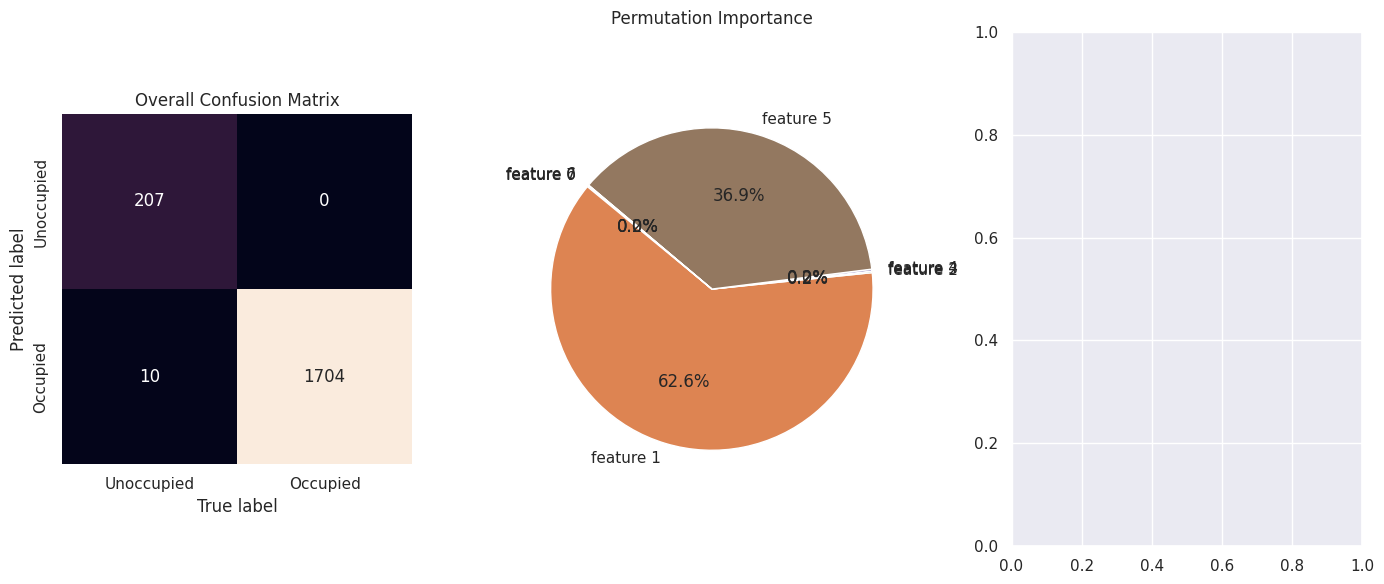

In [ ]:
# random forest
rd_forest_madi = RandomForestLearningAlgorithm(n_estimators = 300, criterion = 'gini', max_depth = 5, min_samples_split = 2)
verifier_train_eval(rd_forest_madi, x_train, y_train, x_val, y_val, x_test, y_test)

ndarray
Series
[[ 153   64]
 [ 171 1533]]
              precision    recall  f1-score   support

           0       0.47      0.71      0.57       217
           1       0.96      0.90      0.93      1704

    accuracy                           0.88      1921
   macro avg       0.72      0.80      0.75      1921
weighted avg       0.90      0.88      0.89      1921

Feature 0: -0.013 (±0.003)
Feature 1: 0.028 (±0.003)
Feature 2: -0.014 (±0.003)
Feature 3: 0.019 (±0.003)
Feature 4: -0.004 (±0.002)
Feature 5: 0.033 (±0.003)
Feature 6: -0.006 (±0.002)
Feature 7: -0.010 (±0.001)


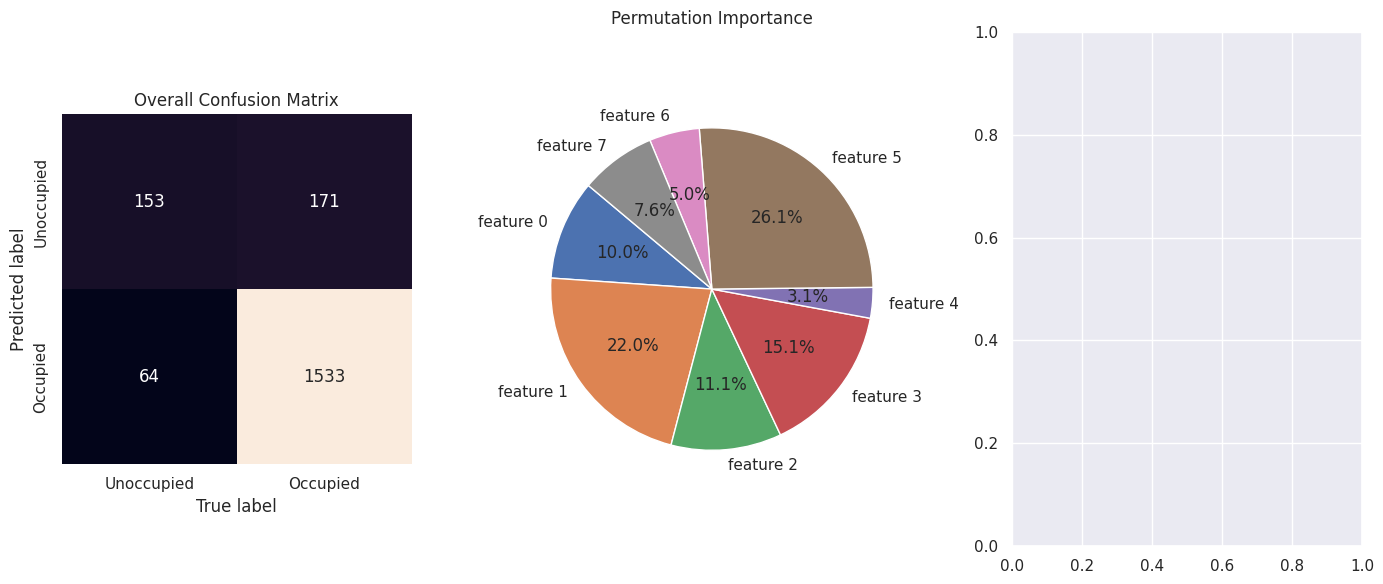

In [ ]:
# iso forest
iso_forest_madi = IsoForestLearningAlgorithm(n_estimators = 300, max_features=0.8)
verifier_train_eval(iso_forest_madi, iso_train, y_train, x_val, y_val, x_test, y_test)

ndarray
Series
[[ 149   68]
 [ 182 1522]]
              precision    recall  f1-score   support

           0       0.45      0.69      0.54       217
           1       0.96      0.89      0.92      1704

    accuracy                           0.87      1921
   macro avg       0.70      0.79      0.73      1921
weighted avg       0.90      0.87      0.88      1921

Feature 0: 0.010 (±0.005)
Feature 1: 0.022 (±0.004)
Feature 2: 0.003 (±0.005)
Feature 3: 0.001 (±0.000)
Feature 4: -0.021 (±0.004)
Feature 5: 0.001 (±0.000)
Feature 6: 0.003 (±0.003)
Feature 7: 0.002 (±0.006)


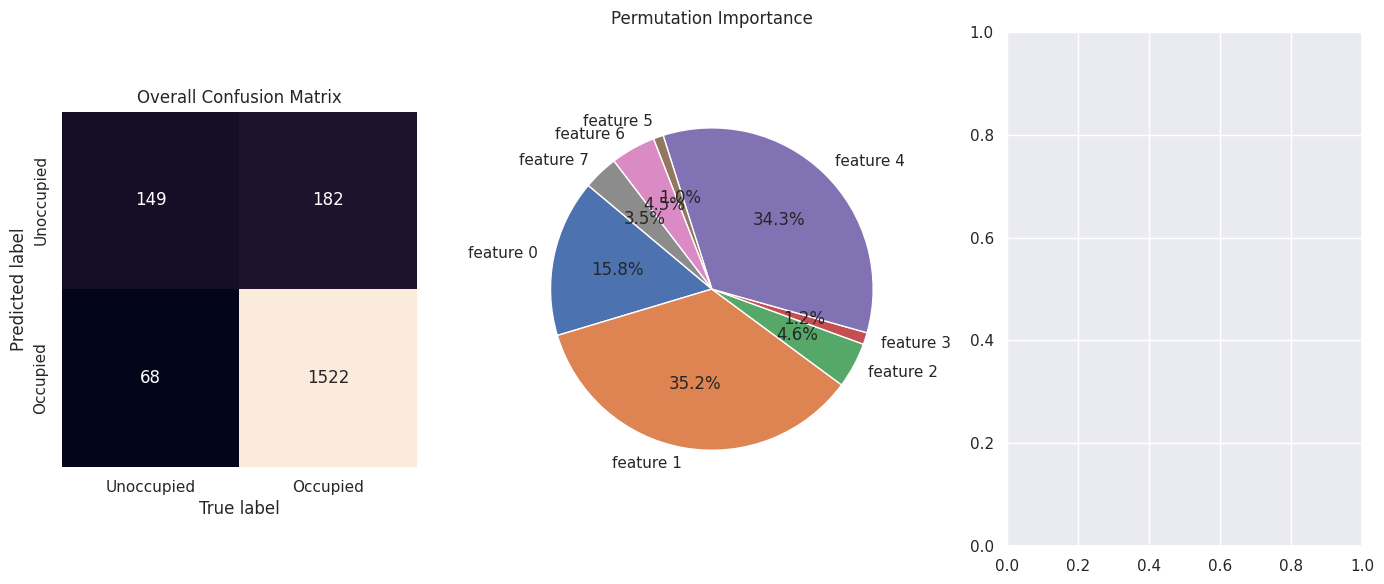

In [ ]:
# one class SVM
oSVM = OneClassSVMLearningAlgorithm()
verifier_train_eval(oSVM, iso_train, y_train, x_val, y_val, x_test, y_test)

Epoch 1/1000


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


55/55 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 0.9796 - val_loss: 0.5969
Epoch 2/1000
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.5907 - val_loss: 0.5735
Epoch 3/1000
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.5724 - val_loss: 0.5675
Epoch 4/1000
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.5620 - val_loss: 0.5638
Epoch 5/1000
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.5611 - val_loss: 0.5616
Epoch 6/1000
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.5576 - val_loss: 0.5587
Epoch 7/1000
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.5516 - val_loss: 0.5562
Epoch 8/1000
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.5528 - val_loss: 0.5561
Epoch 9/1000
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.5536 - val_loss: 0.5455
Epoch 10/1000
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.5413 - val_loss: 0.5440
Epoch 11/1000
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.5429 - val_loss: 0.5431
Epoch 12/1000
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step 

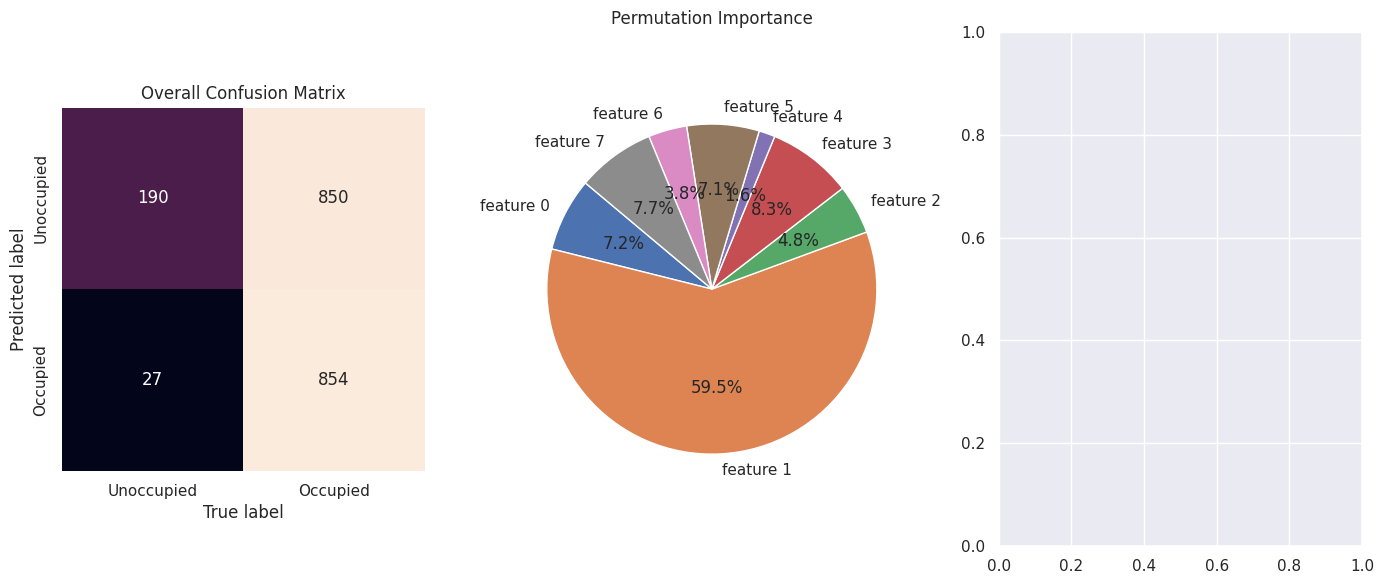

In [ ]:
# auto encoder
ae_x_train = scaler.fit_transform(iso_train.to_numpy())
ae_y_train = y_train.to_numpy()
ae_x_val = scaler.fit_transform(x_val.to_numpy())
ae_y_val = y_val.to_numpy()
ae_x_test = scaler.fit_transform(x_test.to_numpy())
ae_y_test = y_test.to_numpy()

autoencoder = AutoEncoderLearningAlgorithm(ae_x_train.shape[1])
verifier_train_eval(autoencoder, ae_x_train, ae_y_train, ae_x_val, ae_y_val, ae_x_test, ae_y_test)